### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm

### Data Cleaning

In [3]:
df = pd.read_csv("parcelCenter.csv")

In [4]:
df.isna().sum()

parcel_id              0
parcel_type            0
enter_time             0
leave_time             0
unloading_container    0
unloading_port         0
loading_container      0
loading_port           0
dtype: int64

In [5]:
# Convert enter_time and leave_time to datetime format
df["enter_time"] = pd.to_datetime(df["enter_time"], format="%d/%m/%y %H:%M")
df["leave_time"] = pd.to_datetime(df["leave_time"], format="%d/%m/%y %H:%M")

# Compute processing time in minutes
df["processing_time"] = (df["leave_time"] - df["enter_time"]).dt.total_seconds() / 60

# Create a new column for hour of entry (for congestion analysis)
df["hour_of_entry"] = df["enter_time"].dt.hour

In [6]:
# Sort by enter_time
df = df.sort_values(by='enter_time')

# Create a new column for facility congestion at entry time
congestion_counts = []

for i, row in df.iterrows():
    # Count parcels present at the time this parcel enters
    count = df[(df['enter_time'] <= row['enter_time']) & (df['leave_time'] > row['enter_time'])].shape[0]
    congestion_counts.append(count)

# Add to DataFrame
df['congestion'] = congestion_counts

In [7]:
# Renamed categories for parcel_type
df['parcel_type'] = df['parcel_type'].replace('I', 'International')
df['parcel_type'] = df['parcel_type'].replace('D', 'Domestic')

In [8]:
df

,parcel_id,parcel_type,enter_time,leave_time,unloading_container,unloading_port,loading_container,loading_port,processing_time,hour_of_entry,congestion
641,s11780I298012,International,2021-05-17 08:02:00,2021-05-17 08:33:00,CI11780,SE01,CO11801,TN01,31.0,8,8
282,s11780I789965,International,2021-05-17 08:02:00,2021-05-17 08:19:00,CI11780,SE01,CO11801,TN01,17.0,8,8
704,s11780I658190,International,2021-05-17 08:02:00,2021-05-17 08:23:00,CI11780,SE01,CO11801,TN01,21.0,8,8
493,s11780I061877,International,2021-05-17 08:02:00,2021-05-17 08:23:00,CI11780,SE01,CO11801,TN01,21.0,8,8
303,s11780I354406,International,2021-05-17 08:02:00,2021-05-17 08:35:00,CI11780,SE01,CO11801,TN01,33.0,8,8
...,...,...,...,...,...,...,...,...,...,...,...
117,s11788D719093,Domestic,2021-05-17 10:37:00,2021-05-17 10:57:00,CI11788,SN01,CO11799,TS02,20.0,10,112
269,s11788D757671,Domestic,2021-05-17 10:37:00,2021-05-17 10:51:00,CI11788,SN01,CO11799,TS02,14.0,10,112
664,s11788D120119,Domestic,2021-05-17 10:37:00,2021-05-17 10:58:00,CI11788,SN01,CO11799,TS02,21.0,10,112
497,s11788D127347,Domestic,2021-05-17 10:38:00,2021-05-17 10:53:00,CI11788,SN01,CO11799,TS02,15.0,10,107


### Data Visualization

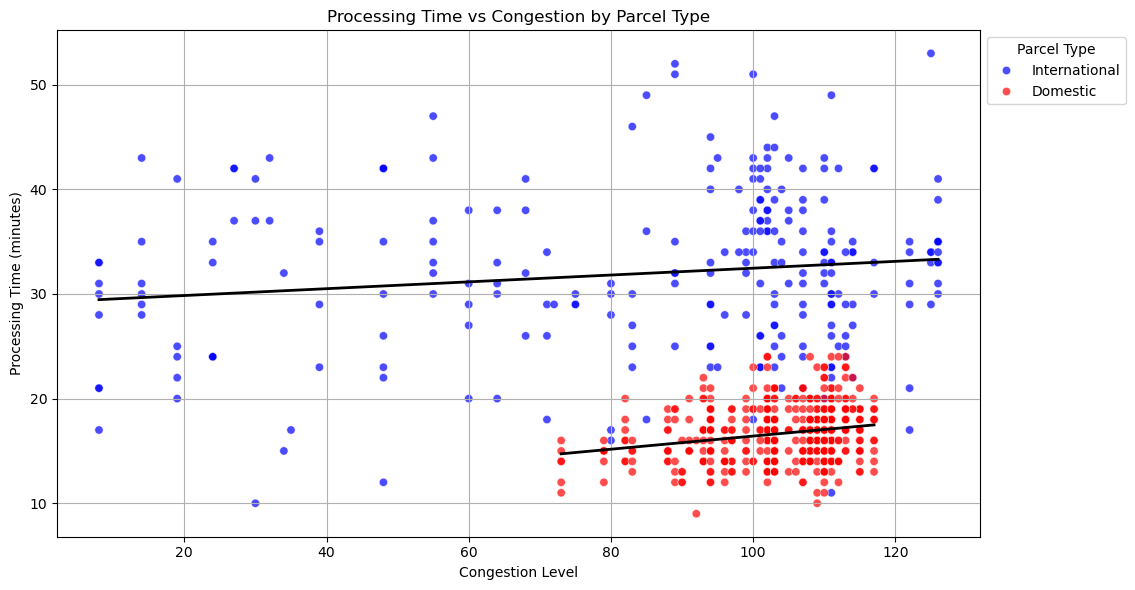

In [9]:
# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Scatter plot using seaborn
scatter = sns.scatterplot(
    data=df,
    x='congestion',
    y='processing_time',
    hue='parcel_type',
    palette={'Domestic': 'red', 'International': 'blue'},
    alpha=0.7
)

# Add linear regression lines (black) for each parcel type without adding them to legend
for parcel_type in df['parcel_type'].unique():
    subset = df[df['parcel_type'] == parcel_type]
    z = np.polyfit(subset['congestion'], subset['processing_time'], 1)
    p = np.poly1d(z)
    plt.plot(
        np.sort(subset['congestion']),
        p(np.sort(subset['congestion'])),
        color='black',
        linestyle='-',
        linewidth=2
    )

# Customize and display the plot
plt.title('Processing Time vs Congestion by Parcel Type')
plt.xlabel('Congestion Level')
plt.ylabel('Processing Time (minutes)')
plt.grid(True)
plt.tight_layout()

# Place legend outside the plot
plt.legend(title='Parcel Type', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

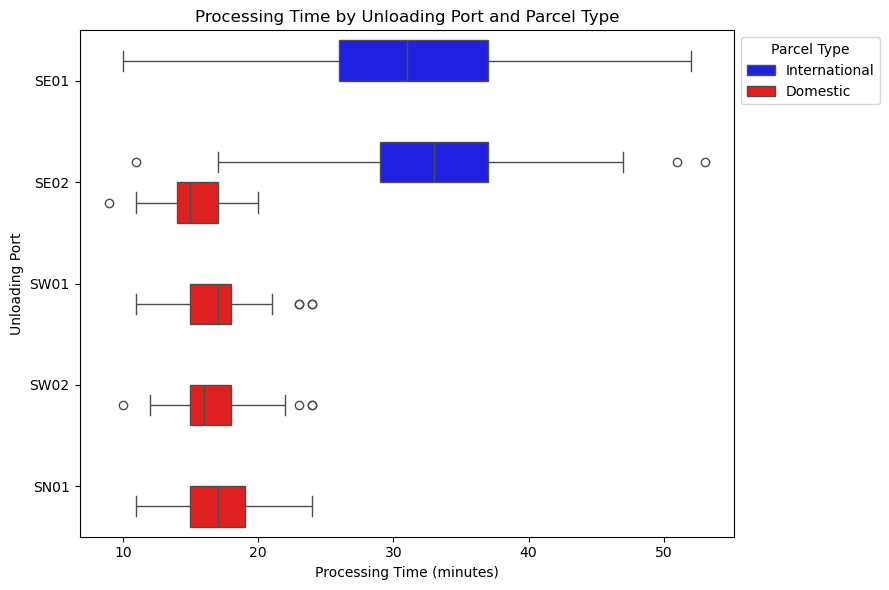

In [10]:
# Set the size of the figure
plt.figure(figsize=(9, 6))

# Create the box plot
sns.boxplot(
    data=df,
    x='processing_time',
    y='unloading_port',
    hue='parcel_type',
    palette={'Domestic': 'red', 'International': 'blue'}
)

# Customize the plot
plt.title('Processing Time by Unloading Port and Parcel Type')
plt.xlabel('Processing Time (minutes)')
plt.ylabel('Unloading Port')
plt.legend(title='Parcel Type', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()

In [11]:
# Create interactive box plot
fig = px.box(
    df,
    x='processing_time',
    y='unloading_port',
    color='parcel_type',
    title='Processing Time by Unloading Port and Parcel Type',
    labels={
        'processing_time': 'Processing Time (minutes)',
        'unloading_port': 'Unloading Port',
        'parcel_type': 'Parcel Type'
    },
    color_discrete_map={'Domestic': 'red', 'International': 'blue'}
)

fig.show()

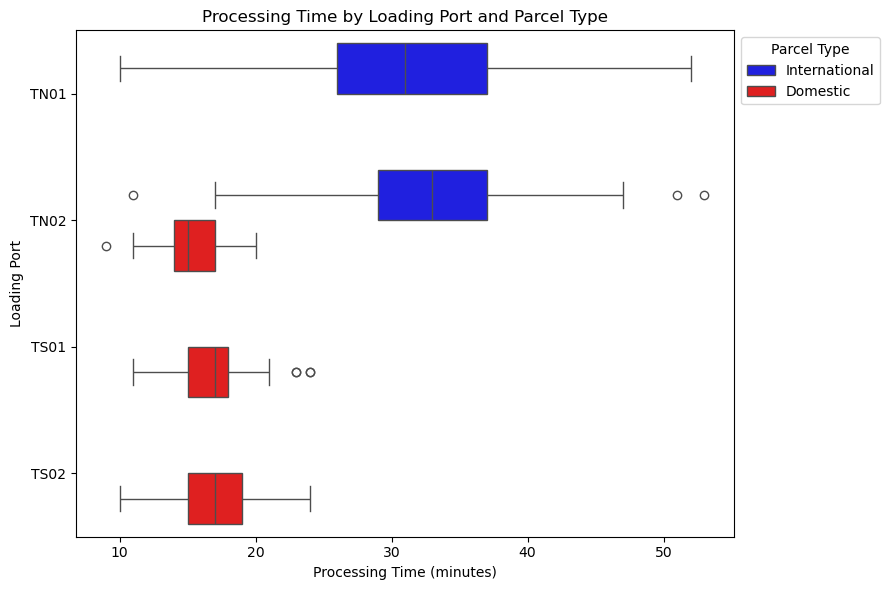

In [12]:
# Set the size of the figure
plt.figure(figsize=(9, 6))

# Create the box plot
sns.boxplot(
    data=df,
    x='processing_time',
    y='loading_port',
    hue='parcel_type',
    palette={'Domestic': 'red', 'International': 'blue'}
)

# Customize the plot
plt.title('Processing Time by Loading Port and Parcel Type')
plt.xlabel('Processing Time (minutes)')
plt.ylabel('Loading Port')
plt.legend(title='Parcel Type', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()

In [13]:
# Create interactive box plot
fig = px.box(
    df,
    x='processing_time',
    y='loading_port',
    color='parcel_type',
    title='Processing Time by Loading Port and Parcel Type',
    labels={
        'processing_time': 'Processing Time (minutes)',
        'loading_port': 'Loading Port',
        'parcel_type': 'Parcel Type'
    },
    color_discrete_map={'Domestic': 'red', 'International': 'blue'}
)

fig.show()

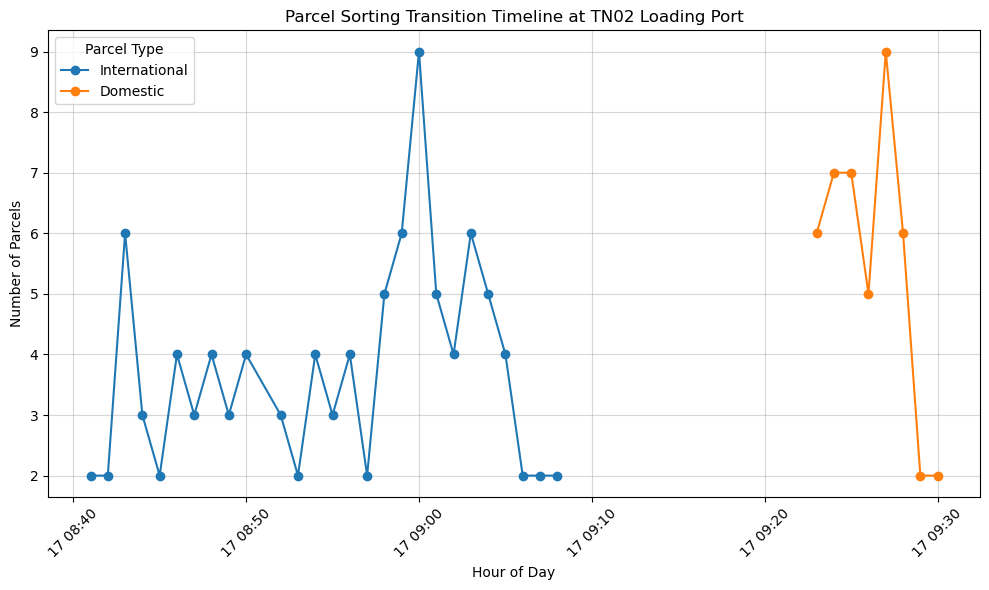

In [14]:
df_filtered = df[df['loading_port'] == 'TN02']

# Count number of parcels per enter_time and parcel_type
lineChart = df_filtered.groupby(['enter_time', 'parcel_type']).size().reset_index(name='count')

# Plot using matplotlib
plt.figure(figsize=(10, 6))

# Plot each parcel_type separately
for parcel_type in lineChart['parcel_type'].unique():
    subset = lineChart[lineChart['parcel_type'] == parcel_type]
    plt.plot(
        subset['enter_time'],
        subset['count'],
        marker='o',
        label=parcel_type
    )

# Customize plot
plt.title('Parcel Sorting Transition Timeline at TN02 Loading Port')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Parcels')
plt.grid(True, alpha=0.5)
plt.xticks(rotation=45)
plt.legend(title='Parcel Type')
plt.grid(True, )
plt.tight_layout()

plt.show()

### Linear Regression

In [15]:
# One hot encoding
df = pd.get_dummies(df, columns=['parcel_type'], drop_first=True, dtype = int)

In [16]:
lm = sm.OLS.from_formula('processing_time ~ parcel_type_International + congestion', data=df)
result = lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        processing_time   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     762.5
Date:                Thu, 17 Apr 2025   Prob (F-statistic):          5.04e-178
Time:                        22:47:04   Log-Likelihood:                -2175.6
No. Observations:                 718   AIC:                             4357.
Df Residuals:                     715   BIC:                             4371.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             